<a href="https://colab.research.google.com/github/FarrelAD/Hology-8-2025-Data-Mining-PRIVATE/blob/dev%2Ffarrel/notebooks/vidi/train_sfcn_fpn_notebook_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SFCN Training Notebook
# Scale-aware Feature Pyramid Network for Crowd Counting

This notebook implements SFCN with FPN backbone, hybrid detection mechanism, and comprehensive training pipeline for crowd counting tasks.

## Features:
- VGG16-BN backbone with Feature Pyramid Network (FPN)
- Hybrid detection combining density regression and detection heads
- Advanced data augmentation with CLAHE/HistEq contrast enhancement
- Mixed precision training with gradient accumulation
- Adaptive density map generation with KNN-based sigma
- Early stopping and model checkpointing

In [ ]:
# Import Required Libraries and Setup
import os
import re
import json
import math
from pathlib import Path
import random
import warnings
from glob import glob
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings("ignore")

# Constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA L4
CUDA memory: 23.8 GB


## Dataset Download and Setup

In [ ]:
# @title Setup Kaggle secret key


"""
You don't need to run this cell if you're not in Google Colab environment
"""

!pip install -q kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [ ]:
# @title Setup dataset in Colab

"""
You don't need to run this cell if you're not in Google Colab environment
"""

import zipfile
import os
from google.colab import drive

drive.mount('/content/drive')

# Paths
zip_path = "/content/penyisihan-hology-8-0-2025-data-mining.zip"
drive_extract_path = "/content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset"
local_dataset_path = "/content/dataset"  # for current session

# ---------------------------
# Step 1: Download zip (if not exists in /content)
# ---------------------------
if not os.path.exists(zip_path):
    print("Dataset not found locally, downloading...")
    !kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining -p /content
else:
    print("Dataset already exists, skipping download.")

# ---------------------------
# Step 2: Extract to Google Drive (for backup)
# ---------------------------
os.makedirs(drive_extract_path, exist_ok=True)

if not os.listdir(drive_extract_path):  # Check if folder is empty
    print("Extracting dataset to Google Drive...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(drive_extract_path)
    print("Dataset extracted to:", drive_extract_path)
else:
    print("Dataset already extracted at:", drive_extract_path)

# ---------------------------
# Step 3: Copy dataset to local /content (faster training)
# ---------------------------
if not os.path.exists(local_dataset_path):
    print("Copying dataset to Colab local storage (/content)...")
    !cp -r "$drive_extract_path" "$local_dataset_path"
else:
    print("Dataset already available in Colab local storage.")

Mounted at /content/drive
Dataset not found locally, downloading...
 61% 127M/209M [00:00<00:00, 1.33GB/s]
100% 209M/209M [00:00<00:00, 1.35GB/s]
Dataset already extracted at: /content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset
Copying dataset to Colab local storage (/content)...


## Configuration and Hyperparameters

Set up all training configuration parameters. You can modify these values to experiment with different settings.

In [ ]:
# Training Configuration
config = {
    # Data paths
    'img_dir': Path(local_dataset_path) / "train" / "images", # 'data/train/images' for local path
    'label_dir': Path(local_dataset_path) / "train" / "labels",   # 'data/train/labels' for local path
    'test_dir': Path(local_dataset_path) / "test" / "images",    # 'data/test/images' for local path

    # Model parameters
    'base_size': 1024,
    'down': 8,
    'patch_size': 512,
    'patches_per_image': 6,
    'avoid_empty_patches': True,

    # Training parameters
    'batch_size': 12, # change it to 4 for low resource GPU
    'epochs': 120,   # change it to 120
    'lr': 2e-4,
    'criterion': 'huber',  # 'mse' or 'huber'
    'count_loss_alpha': 0.2,
    'det_loss_alpha': 1.0,
    'early_stop_patience': 40,

    # Optimization
    'num_workers': 6,
    'amp': True,  # Automatic Mixed Precision
    'accum_steps': 2,  # Gradient accumulation steps

    # Augmentation and preprocessing
    'sigma_mode': 'adaptive',  # 'adaptive' or 'constant'
    'contrast_mode': 'clahe',  # 'none', 'clahe', 'histeq'
    'clahe_clip': 2.0,
    'clahe_grid': 8,

    # Evaluation
    'hybrid_eval': True,
    'dens_thresh': 0.25,
    'det_prob_thr': 0.5,
    'compare_pred': True,

    # Model saving
    'save_path': 'sfcn_fpn_hybrid_896p384_b4_e300.pth',
    'seed': 1337
}

print("📋 Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Set random seed for reproducibility
def set_seed(seed: int = 1337) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config['seed'])
print(f"🎲 Random seed set to {config['seed']}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")

📋 Configuration loaded:
  img_dir: /content/dataset/train/images
  label_dir: /content/dataset/train/labels
  test_dir: /content/dataset/test/images
  base_size: 896
  down: 8
  patch_size: 384
  patches_per_image: 6
  avoid_empty_patches: True
  batch_size: 4
  epochs: 2
  lr: 0.0001
  criterion: huber
  count_loss_alpha: 0.2
  det_loss_alpha: 1.0
  early_stop_patience: 40
  num_workers: 6
  amp: True
  accum_steps: 2
  sigma_mode: adaptive
  contrast_mode: clahe
  clahe_clip: 2.0
  clahe_grid: 8
  hybrid_eval: True
  dens_thresh: 0.25
  det_prob_thr: 0.5
  compare_pred: True
  save_path: sfcn_fpn_hybrid_896p384_b4_e300.pth
  seed: 1337
🎲 Random seed set to 1337
🔧 Using device: cuda


## Utility Functions

Implement essential utility functions for image processing, point parsing, and density map generation.

In [ ]:
def imread_rgb(
    path: str
) -> np.ndarray:
    """Load image in RGB format."""
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def letterbox(
    img: np.ndarray,
    target: int = 512
) -> Tuple[np.ndarray, float, int, int]:
    """Resize image to target size while maintaining aspect ratio with letterboxing."""
    h, w = img.shape[:2]
    scale = min(target / h, target / w)
    nh, nw = int(round(h * scale)), int(round(w * scale))
    img_rs = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)
    top = (target - nh) // 2
    left = (target - nw) // 2
    canvas = np.zeros((target, target, 3), dtype=img_rs.dtype)
    canvas[top:top + nh, left:left + nw] = img_rs
    return canvas, scale, left, top

def parse_points_from_json(
    path: str
) -> Tuple[np.ndarray, int]:
    """Parse annotation points from JSON file."""
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)

    pts, num = [], None
    if isinstance(obj, dict) and "points" in obj:
        pts = obj["points"]
        num = obj.get("human_num", obj.get("num_human", None))
        if len(pts) and isinstance(pts[0], dict):
            pts = [[p["x"], p["y"]] for p in pts if "x" in p and "y" in p]
    elif isinstance(obj, dict) and "annotations" in obj:
        pts = [[a["x"], a["y"]] for a in obj["annotations"] if "x" in a and "y" in a]
        num = obj.get("human_num", obj.get("num_human", None))
    elif isinstance(obj, list):
        pts = obj
    else:
        raise ValueError(f"Unknown JSON schema: {path}")

    pts_arr = np.array(pts, dtype=np.float32) if len(pts) > 0 else np.zeros((0, 2), np.float32)
    return pts_arr, num

def derive_json_path(
    label_dir: str,
    img_path: str
) -> str:
    """Find corresponding JSON label file for image."""
    name = os.path.splitext(os.path.basename(img_path))[0]
    cand = os.path.join(label_dir, name + ".json")
    if os.path.exists(cand):
        return cand

    m = re.findall(r"\d+", name)
    if m:
        alt = os.path.join(label_dir, f"{m[-1]}.json")
        if os.path.exists(alt):
            return alt

    lst = glob(os.path.join(label_dir, f"{name}*.json"))
    if lst:
        return lst[0]

    raise FileNotFoundError(f"JSON label not found for {img_path}")

print("✅ Basic utility functions defined!")

✅ Basic utility functions defined!


In [ ]:
def make_density_map(
    points_xy: np.ndarray,
    grid_size: int,
    down: int = 8,
    sigma_mode: str = "adaptive",
    knn: int = 3,
    beta: float = 0.3,
    const_sigma: float = 2.0
) -> np.ndarray:
    """Generate density map from point annotations."""
    target = grid_size
    dh, dw = target // down, target // down
    den = np.zeros((dh, dw), dtype=np.float32)

    if len(points_xy) == 0:
        return den

    pts = points_xy.copy()
    pts[:, 0] = pts[:, 0] * (dw / target)
    pts[:, 1] = pts[:, 1] * (dh / target)

    tree = KDTree(pts) if len(pts) > 1 else None

    for (x, y) in pts:
        if sigma_mode == "adaptive" and tree is not None and len(pts) > 3:
            dists, _ = tree.query([x, y], k=min(knn + 1, len(pts)))
            sigma = max(1.0, float(np.mean(dists[1:])) * beta)
        else:
            sigma = const_sigma

        cx, cy = float(x), float(y)
        rad = int(max(1, math.ceil(3 * sigma)))
        x0, x1 = max(0, int(math.floor(cx - rad))), min(dw, int(math.ceil(cx + rad + 1)))
        y0, y1 = max(0, int(math.floor(cy - rad))), min(dh, int(math.ceil(cy + rad + 1)))

        if x1 <= x0 or y1 <= y0:
            continue

        xs = np.arange(x0, x1) - cx
        ys = np.arange(y0, y1) - cy
        xx, yy = np.meshgrid(xs, ys)
        g = np.exp(-(xx**2 + yy**2) / (2 * sigma * sigma))
        s = g.sum()
        if s > 0:
            den[y0:y1, x0:x1] += (g / s).astype(np.float32)

    return den

def make_occupancy_map(
    points_xy: np.ndarray,
    grid_size: int,
    down: int = 8,
    radius: int = 1
) -> np.ndarray:
    """Generate binary occupancy map from point annotations."""
    target = grid_size
    dh, dw = target // down, target // down
    occ = np.zeros((dh, dw), dtype=np.float32)

    if len(points_xy) == 0:
        return occ

    pts = points_xy.copy()
    pts[:, 0] = pts[:, 0] * (dw / target)
    pts[:, 1] = pts[:, 1] * (dh / target)

    for (x, y) in pts:
        xi, yi = int(round(x)), int(round(y))
        x0, x1 = max(0, xi - radius), min(dw - 1, xi + radius)
        y0, y1 = max(0, yi - radius), min(dh - 1, yi + radius)
        occ[y0:y1 + 1, x0:x1 + 1] = 1.0

    return occ

def apply_contrast_enhancement(
    img_rgb: np.ndarray,
    mode: str = "none",
    clahe_clip: float = 2.0,
    clahe_grid: int = 8
) -> np.ndarray:
    """Apply contrast enhancement to image."""
    if mode == "none":
        return img_rgb
    elif mode == "clahe":
        lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(clahe_grid, clahe_grid))
        l2 = clahe.apply(l)
        return cv2.cvtColor(cv2.merge([l2, a, b]), cv2.COLOR_LAB2RGB)
    elif mode == "histeq":
        ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)
        y, cr, cb = cv2.split(ycrcb)
        y2 = cv2.equalizeHist(y)
        return cv2.cvtColor(cv2.merge([y2, cr, cb]), cv2.COLOR_YCrCb2RGB)

    return img_rgb

print("✅ Density map and contrast enhancement functions defined!")

✅ Density map and contrast enhancement functions defined!


## Dataset Implementation

Create the CrowdDataset class with comprehensive data augmentation and preprocessing capabilities.

In [ ]:
class CrowdDataset(Dataset):
    def __init__(
        self,
        img_dir: str,
        label_dir: str = None,
        base_size: int = 768,
        down: int = 8,
        aug: bool = True,
        mode: str = "train",
        patch_size: int = 0,
        patches_per_image: int = 1,
        sigma_mode: str = "adaptive",
        avoid_empty_patches: bool = False,
        contrast_mode: str = "none",
        clahe_clip: float = 2.0,
        clahe_grid: int = 8
    ) -> None:
        super().__init__()
        self.img_paths = sorted(glob(os.path.join(img_dir, "*.*")))
        if len(self.img_paths) == 0:
            raise ValueError(f"No images found in {img_dir}")

        self.label_dir = label_dir
        self.base_size = base_size
        self.down = down
        self.aug = aug
        self.mode = mode
        self.patch_size = patch_size
        self.patches_per_image = max(1, int(patches_per_image))
        self.sigma_mode = sigma_mode
        self.avoid_empty_patches = avoid_empty_patches
        self.contrast_mode = contrast_mode
        self.clahe_clip = clahe_clip
        self.clahe_grid = clahe_grid

        # Transform pipeline
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        self.color_jit = transforms.ColorJitter(0.1, 0.1, 0.1, 0.05)
        self.extra_aug = transforms.Compose([
            transforms.RandomApply([transforms.RandomGrayscale(p=1.0)], p=0.15),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.30),
            transforms.RandomResizedCrop(size=base_size, scale=(0.80, 1.00), ratio=(0.90, 1.10)),
        ])
        self.rand_erase = transforms.RandomErasing(
            p=0.25, scale=(0.02, 0.20), ratio=(0.3, 3.3), value=0
        )

        if mode == "test":
            self.effective_len = len(self.img_paths)
        elif mode == "train" and patch_size > 0 and patches_per_image > 1:
            self.effective_len = len(self.img_paths) * self.patches_per_image
        else:
            self.effective_len = len(self.img_paths)


    def __len__(self) -> int:
        return self.effective_len

    def _load_img_pts(
        self,
        idx_base: int
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Load and preprocess image with corresponding points."""
        pimg = self.img_paths[idx_base]
        img = imread_rgb(pimg)
        h, w = img.shape[:2]

        # Apply contrast enhancement
        img = apply_contrast_enhancement(img, self.contrast_mode, self.clahe_clip, self.clahe_grid)

        # Load points
        plbl = derive_json_path(self.label_dir, pimg)
        pts, _ = parse_points_from_json(plbl)

        # Data augmentation
        if self.mode == "train" and self.aug and random.random() < 0.5:
            # Horizontal flip
            img = img[:, ::-1, :].copy()
            if len(pts) > 0:
                pts = pts.copy()
                pts[:, 0] = (w - 1) - pts[:, 0]

        if self.mode == "train" and self.aug and random.random() < 0.5:
            # Color jitter
            pil = transforms.ToPILImage()(img)
            pil = self.color_jit(pil)
            img = np.array(pil)

        if self.mode == "train" and self.aug:
            # Extra augmentations
            pil = transforms.ToPILImage()(img)
            pil = self.extra_aug(pil)
            img = np.array(pil)

        # Letterbox resize
        canvas, scale, left, top = letterbox(img, target=self.base_size)
        if len(pts) > 0:
            pts_tr = pts.copy()
            pts_tr[:, 0] = pts_tr[:, 0] * scale + left
            pts_tr[:, 1] = pts_tr[:, 1] * scale + top
            # Filter points within canvas
            m = ((pts_tr[:, 0] >= 0) & (pts_tr[:, 0] < self.base_size) &
                 (pts_tr[:, 1] >= 0) & (pts_tr[:, 1] < self.base_size))
            pts_tr = pts_tr[m]
        else:
            pts_tr = np.zeros((0, 2), np.float32)

        return canvas, pts_tr

    def __getitem__(
        self,
        index: int
    ):
        idx_base = (index // self.patches_per_image
                   if (self.mode == "train" and self.patch_size > 0 and self.patches_per_image > 1)
                   else index)
        idx_base %= len(self.img_paths)
        pimg = self.img_paths[idx_base]

        if self.mode == "test":
          img = imread_rgb(pimg)
          img = apply_contrast_enhancement(img, self.contrast_mode, self.clahe_clip, self.clahe_grid)
          canvas, _, _, _ = letterbox(img, target=self.base_size)
          t = self.to_tensor(canvas)
          t = self.normalize(t)
          image_name = os.path.basename(pimg)
          return t, image_name

        img_lb, pts_tr = self._load_img_pts(idx_base)

        # Patch-based training
        if self.mode == "train" and self.patch_size > 0:
            ps = self.patch_size
            max_off = self.base_size - ps
            for attempt in range(10 if self.avoid_empty_patches else 1):
                ox = 0 if max_off <= 0 else random.randint(0, max_off)
                oy = 0 if max_off <= 0 else random.randint(0, max_off)
                crop = img_lb[oy:oy + ps, ox:ox + ps, :]

                if len(pts_tr) > 0:
                    pts_c = pts_tr.copy()
                    pts_c[:, 0] -= ox
                    pts_c[:, 1] -= oy
                    m = ((pts_c[:, 0] >= 0) & (pts_c[:, 0] < ps) &
                         (pts_c[:, 1] >= 0) & (pts_c[:, 1] < ps))
                    pts_c = pts_c[m]
                else:
                    pts_c = np.zeros((0, 2), np.float32)

                if not self.avoid_empty_patches or len(pts_c) > 0 or attempt == 9:
                    img_out = crop
                    pts_out = pts_c
                    break
            grid = ps
        else:
            img_out = img_lb
            pts_out = pts_tr
            grid = self.base_size

        # Generate density and occupancy maps
        den = make_density_map(pts_out, grid_size=grid, down=self.down, sigma_mode=self.sigma_mode)
        occ = make_occupancy_map(pts_out, grid_size=grid, down=self.down, radius=1)

        # Convert to tensors
        t = self.to_tensor(img_out)
        if self.mode == "train" and self.aug:
            t = self.rand_erase(t)
        t = self.normalize(t)

        d = torch.from_numpy(den).unsqueeze(0)
        o = torch.from_numpy(occ).unsqueeze(0)
        c = torch.tensor([float(len(pts_out))], dtype=torch.float32)

        return t, d, c, o

print("✅ CrowdDataset class implemented!")

✅ CrowdDataset class implemented!


## Model Architecture (SFCN with FPN)

Implement the SFCN model with VGG16-BN backbone, Feature Pyramid Network, and dual prediction heads.

In [ ]:
class SpatialEncoder(nn.Module):
    """Spatial Feature Encoder with horizontal and vertical convolutions."""

    def __init__(
        self,
        channels: int,
        k: int = 9
    ) -> None:
        super().__init__()
        p = k // 2
        self.h1 = nn.Conv2d(channels, channels, (1, k), padding=(0, p), groups=channels, bias=False)
        self.h2 = nn.Conv2d(channels, channels, (1, k), padding=(0, p), groups=channels, bias=False)
        self.v1 = nn.Conv2d(channels, channels, (k, 1), padding=(p, 0), groups=channels, bias=False)
        self.v2 = nn.Conv2d(channels, channels, (k, 1), padding=(p, 0), groups=channels, bias=False)
        self.proj = nn.Conv2d(channels * 4, channels, 1, bias=False)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        # Collect outputs
        features = [self.h1(x), self.h2(x), self.v1(x), self.v2(x)]

        # Concatenate along channel dimension
        concatenated = torch.cat(features, dim=1)

        # Apply projection and activation
        projected = self.proj(concatenated)
        activated = self.act(projected)

        return activated


class SFCN_VGG_FPN(nn.Module):
    """
    SFCN with VGG16-BN backbone and Feature Pyramid Network.
    Outputs (density_map, detection_logits) for hybrid counting.
    """

    def __init__(
        self,
        pretrained: bool = True,
        use_spatial_encoder: bool = True
    ) -> None:
        super().__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1 if pretrained else None)
        self.features = vgg.features  # VGG16-BN features
        self.use_spatial = use_spatial_encoder

        # Lateral connections (1x1 conv to 256 channels)
        self.lat_c2 = nn.Conv2d(128, 256, 1)  # stride 4
        self.lat_c3 = nn.Conv2d(256, 256, 1)  # stride 8
        self.lat_c4 = nn.Conv2d(512, 256, 1)  # stride 16

        # Smooth layers (3x3 conv)
        self.smooth2 = nn.Conv2d(256, 256, 3, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, 3, padding=1)
        self.smooth4 = nn.Conv2d(256, 256, 3, padding=1)

        # Prediction heads
        self.senc = SpatialEncoder(256, k=9) if self.use_spatial else nn.Identity()

        # Density regression head
        self.density_head = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1),
        )

        # Detection head (for hybrid gating)
        self.detect_head = nn.Conv2d(256, 1, 1)

    def _forward_backbone(self, x):
        """Forward through VGG backbone and extract multi-scale features."""
        c2 = c3 = c4 = None
        pool_count = 0

        for i, layer in enumerate(self.features):
            x = layer(x)
            if isinstance(layer, nn.MaxPool2d):
                pool_count += 1
                if pool_count == 2:
                    c2 = x  # stride 4, 128 channels
                elif pool_count == 3:
                    c3 = x  # stride 8, 256 channels
                elif pool_count == 4:
                    c4 = x  # stride 16, 512 channels

        return c2, c3, c4

    def _upsample_add(self, x, y):
        """Upsample x and add to y."""
        return F.interpolate(x, size=y.shape[-2:], mode="nearest") + y

    def forward(self, x):
        # Extract multi-scale features
        c2, c3, c4 = self._forward_backbone(x)

        # Build feature pyramid
        p4 = self.lat_c4(c4)
        p3 = self._upsample_add(p4, self.lat_c3(c3))
        p2 = self._upsample_add(p3, self.lat_c2(c2))

        # Smooth features
        p4 = self.smooth4(p4)
        p3 = self.smooth3(p3)
        p2 = self.smooth2(p2)

        # Use stride-8 features for prediction
        f = p3
        f = self.senc(f)

        # Dual predictions
        dens = F.softplus(self.density_head(f))  # Density map
        det = self.detect_head(f)  # Detection logits

        return dens, det

# Backward compatibility alias
SFCN_VGG = SFCN_VGG_FPN

print("✅ SFCN model architecture implemented!")

# Test model instantiation
model_test = SFCN_VGG_FPN(pretrained=False)
print(f"📊 Model parameters: {sum(p.numel() for p in model_test.parameters()):,}")

# Test forward pass
dummy_input = torch.randn(1, 3, 384, 384)
with torch.no_grad():
    dens_out, det_out = model_test(dummy_input)
    print(f"🔍 Input shape: {dummy_input.shape}")
    print(f"🎯 Density output shape: {dens_out.shape}")
    print(f"🎯 Detection output shape: {det_out.shape}")

del model_test, dummy_input, dens_out, det_out

✅ SFCN model architecture implemented!
📊 Model parameters: 17,364,034
🔍 Input shape: torch.Size([1, 3, 384, 384])
🎯 Density output shape: torch.Size([1, 1, 48, 48])
🎯 Detection output shape: torch.Size([1, 1, 48, 48])


## Training and Evaluation Functions

Implement training and evaluation functions with hybrid loss computation and mixed precision support.

In [ ]:
def train_epoch(
    model,
    loader,
    device,
    optimizer,
    scaler=None,
    accum_steps=1,
    criterion="mse",
    count_loss_alpha=0.0,
    det_loss_alpha=1.0
) -> float:
    """Train model for one epoch with hybrid loss computation."""
    model.train()

    # Loss functions
    if criterion == "mse":
        crit = nn.MSELoss()
    elif criterion == "huber":
        crit = nn.SmoothL1Loss()
    else:
        raise ValueError("criterion must be 'mse' or 'huber'")

    bce = nn.BCEWithLogitsLoss()

    running_mae, nimg = 0.0, 0
    optimizer.zero_grad(set_to_none=True)

    for step, (imgs, dens, _, occ) in enumerate(tqdm(loader, desc="Train", leave=False), 1):
        imgs = imgs.to(device)
        dens = dens.to(device)
        occ = occ.to(device)

        if scaler is not None:
            # Mixed precision training
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                pred_den, pred_det = model(imgs)

                # Compute losses
                map_loss = crit(pred_den, dens)
                det_loss = bce(pred_det, occ)
                total_loss = map_loss + det_loss_alpha * det_loss

                if count_loss_alpha > 0.0:
                    count_loss = F.mse_loss(pred_den.sum((1, 2, 3)), dens.sum((1, 2, 3)))
                    total_loss = total_loss + count_loss_alpha * count_loss

                total_loss = total_loss / accum_steps

            scaler.scale(total_loss).backward()

            if step % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        else:
            # Regular training
            pred_den, pred_det = model(imgs)

            map_loss = crit(pred_den, dens)
            det_loss = bce(pred_det, occ)
            total_loss = map_loss + det_loss_alpha * det_loss

            if count_loss_alpha > 0.0:
                count_loss = F.mse_loss(pred_den.sum((1, 2, 3)), dens.sum((1, 2, 3)))
                total_loss = total_loss + count_loss_alpha * count_loss

            total_loss = total_loss / accum_steps
            total_loss.backward()

            if step % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)

        # Update metrics
        with torch.no_grad():
            pc = pred_den.sum((1, 2, 3)).detach().cpu().numpy()
            gc = dens.sum((1, 2, 3)).detach().cpu().numpy()
            running_mae += np.abs(pc - gc).sum()
            nimg += imgs.size(0)

    return running_mae / max(1, nimg)


@torch.no_grad()
def evaluate(
    model,
    loader,
    device,
    dens_thresh: float = 0.25,
    det_prob_thr: float = 0.5,
    hybrid: bool = True
) -> Tuple[float, float]:
    """Evaluate model with optional hybrid gating mechanism."""
    model.eval()
    mae = mse = nimg = 0.0

    for imgs, dens, _, occ in tqdm(loader, desc="Val", leave=False):
        imgs = imgs.to(device)
        dens = dens.to(device)
        occ = occ.to(device)

        pred_den, pred_det = model(imgs)

        if hybrid:
            # Hybrid gating: use detection probabilities to gate density predictions
            prob = torch.sigmoid(pred_det)
            w = (pred_den < dens_thresh).float() * prob
            comb = (1.0 - w) * pred_den + w * prob
            pred_cnt = comb.sum((1, 2, 3))
        else:
            pred_cnt = pred_den.sum((1, 2, 3))

        diff = (pred_cnt - dens.sum((1, 2, 3))).detach().cpu().numpy()
        mae += np.abs(diff).sum()
        mse += (diff**2).sum()
        nimg += imgs.size(0)

    return mae / max(1, nimg), math.sqrt(mse / max(1, nimg))

print("✅ Training and evaluation functions implemented!")

✅ Training and evaluation functions implemented!


## Data Loading and Preparation

Set up datasets and data loaders for training and validation.

In [ ]:
# Check if data directories exist
img_dir = config['img_dir']
label_dir = config['label_dir']

print(f"🔍 Checking data directories...")
print(f"   Images: {img_dir} -> {'✅ Exists' if os.path.exists(img_dir) else '❌ Not found'}")
print(f"   Labels: {label_dir} -> {'✅ Exists' if os.path.exists(label_dir) else '❌ Not found'}")

if not os.path.exists(img_dir):
    raise Exception("❌ Image directory not found. Please check the path and try again.")

all_imgs = sorted(glob(os.path.join(img_dir, "*.*")))
print(f"📸 Found {len(all_imgs)} images")

if len(all_imgs) < 2:
    raise Exception("❌ Need at least 2 images for train/val split")


# Split into train/validation
random.shuffle(all_imgs)
n_images = len(all_imgs)
n_val = max(1, int(0.1 * n_images))  # 10% for validation
n_train = n_images - n_val
train_imgs = all_imgs[:n_train]
val_imgs = all_imgs[n_train:]

print(f"📊 Data split: {n_train} train, {n_val} validation")

# Create datasets
print("🔨 Creating datasets...")
train_ds = CrowdDataset(
    img_dir=config['img_dir'],
    label_dir=config['label_dir'],
    base_size=config['base_size'],
    down=config['down'],
    aug=True,
    mode="train",
    patch_size=config['patch_size'],
    patches_per_image=config['patches_per_image'],
    sigma_mode=config['sigma_mode'],
    avoid_empty_patches=config['avoid_empty_patches'],
    contrast_mode=config['contrast_mode'],
    clahe_clip=config['clahe_clip'],
    clahe_grid=config['clahe_grid']
)

val_ds = CrowdDataset(
    img_dir=config['img_dir'],
    label_dir=config['label_dir'],
    base_size=config['base_size'],
    down=config['down'],
    aug=False,
    mode="val",
    patch_size=0,
    patches_per_image=1,
    sigma_mode=config['sigma_mode'],
    avoid_empty_patches=False,
    contrast_mode=config['contrast_mode'],
    clahe_clip=config['clahe_clip'],
    clahe_grid=config['clahe_grid']
)

test_ds = CrowdDataset(
    img_dir=config['test_dir'],
    mode="test",
    base_size=config['base_size'],
    contrast_mode=config['contrast_mode'],
    clahe_clip=config['clahe_clip'],
    clahe_grid=config['clahe_grid']
)


# Set image paths
train_ds.img_paths = train_imgs
val_ds.img_paths = val_imgs
train_ds.effective_len = (len(train_ds.img_paths) * train_ds.patches_per_image
                          if (train_ds.mode == "train" and train_ds.patch_size > 0 and train_ds.patches_per_image > 1)
                          else len(train_ds.img_paths))
val_ds.effective_len = len(val_ds.img_paths)

print(f"📦 Training dataset: {len(train_ds)} samples")
print(f"📦 Validation dataset: {len(val_ds)} samples")
print(f"📦 Test dataset: {len(test_ds)} samples")

# Create data loaders
train_loader = DataLoader(
    train_ds,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=16,
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True
)

print(f"🚀 Data loaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

🔍 Checking data directories...
   Images: /content/dataset/train/images -> ✅ Exists
   Labels: /content/dataset/train/labels -> ✅ Exists
📸 Found 1900 images
📊 Data split: 1710 train, 190 validation
🔨 Creating datasets...
📦 Training dataset: 10260 samples
📦 Validation dataset: 190 samples
📦 Test dataset: 500 samples
🚀 Data loaders created!
   Train batches: 2565
   Val batches: 48
   Test batches: 32


## Model Training Loop

Initialize the model, optimizer, and execute the main training loop with early stopping and checkpointing.

In [ ]:
# Initialize model and training components
print("🏗️  Initializing model and training components...")

# Create model
model = SFCN_VGG_FPN(pretrained=True).to(device)
print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler() if (config['amp'] and device.type == "cuda") else None
print(f"⚡ Mixed precision: {'Enabled' if scaler is not None else 'Disabled'}")

# Training state
best_mae = float("inf")
patience = config['early_stop_patience']
bad_epochs = 0
training_history = {
    'train_mae': [],
    'val_mae': [],
    'val_rmse': [],
    'epoch': []
}

print("✅ Setup complete! Starting training...")
print("="*60)

🏗️  Initializing model and training components...
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:02<00:00, 213MB/s]


📊 Model parameters: 17,364,034
⚡ Mixed precision: Enabled
✅ Setup complete! Starting training...


In [12]:
# Main Training Loop
for epoch in range(1, config['epochs'] + 1):
    print(f"\n📈 Epoch {epoch}/{config['epochs']}")

    # Training phase
    tr_mae = train_epoch(
        model, train_loader, device, optimizer, scaler,
        accum_steps=config['accum_steps'],
        criterion=config['criterion'],
        count_loss_alpha=config['count_loss_alpha'],
        det_loss_alpha=config['det_loss_alpha']
    )

    # Validation phase
    va_mae, va_rmse = evaluate(
        model, val_loader, device,
        dens_thresh=config['dens_thresh'],
        det_prob_thr=config['det_prob_thr'],
        hybrid=config['hybrid_eval']
    )

    # Learning rate scheduling
    scheduler.step()

    # Update training history
    training_history['train_mae'].append(tr_mae)
    training_history['val_mae'].append(va_mae)
    training_history['val_rmse'].append(va_rmse)
    training_history['epoch'].append(epoch)

    # Print metrics
    print(f"📊 Train MAE: {tr_mae:.3f} | Val MAE: {va_mae:.3f} | Val RMSE: {va_rmse:.3f}")
    print(f"🎯 Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Model checkpointing
    if va_mae + 1e-6 < best_mae:
        best_mae = va_mae
        bad_epochs = 0

        # Save checkpoint
        checkpoint = {
            "model": model.state_dict(),
            "epoch": epoch,
            "val_mae": va_mae,
            "config": config,
            "training_history": training_history
        }
        torch.save(checkpoint, config['save_path'])
        print(f"✅ New best model saved! MAE: {best_mae:.3f}")

        # Optional: Print GT vs Pred comparison for validation set
        if config['compare_pred'] and epoch % 10 == 0:  # Every 10 epochs to avoid spam
            print(f"📋 Sample GT vs Pred comparison (Epoch {epoch}):")
            model.eval()
            sample_count = 0
            with torch.no_grad():
                for imgs, dens, _, occ in val_loader:
                    if sample_count >= 5:  # Show only first 5 samples
                        break

                    imgs = imgs.to(device)
                    dens = dens.to(device)
                    pred_den, pred_det = model(imgs)

                    if config['hybrid_eval']:
                        prob = torch.sigmoid(pred_det)
                        w = (pred_den < config['dens_thresh']).float() * prob
                        comb = (1.0 - w) * pred_den + w * prob
                        pred_cnt_batch = comb.sum((1, 2, 3))
                    else:
                        pred_cnt_batch = pred_den.sum((1, 2, 3))

                    gt_cnt_batch = dens.sum((1, 2, 3))

                    for j in range(min(pred_cnt_batch.size(0), 5 - sample_count)):
                        idx = sample_count
                        if idx < len(val_ds.img_paths):
                            image_name = os.path.basename(val_ds.img_paths[idx])
                        else:
                            image_name = f"sample_{idx}"

                        print(f"   {image_name}: GT {gt_cnt_batch[j].item():.1f}, Pred {pred_cnt_batch[j].item():.1f}")
                        sample_count += 1

                    if sample_count >= 5:
                        break
    else:
        bad_epochs += 1
        print(f"⏳ No improvement for {bad_epochs} epoch(s)")

        if bad_epochs >= patience:
            print(f"🛑 Early stopping at epoch {epoch}. Best Val MAE: {best_mae:.3f}")
            break

print("\n" + "="*60)
print(f"🎉 Training completed! Best validation MAE: {best_mae:.3f}")
print(f"💾 Best model saved to: {config['save_path']}")


📈 Epoch 1/120


📊 Train MAE: 217.285 | Val MAE: 160.235 | Val RMSE: 319.171
🎯 Learning Rate: 0.000200
✅ New best model saved! MAE: 160.235

📈 Epoch 2/120


📊 Train MAE: 34.235 | Val MAE: 145.199 | Val RMSE: 327.938
🎯 Learning Rate: 0.000200
✅ New best model saved! MAE: 145.199

📈 Epoch 3/120


📊 Train MAE: 33.686 | Val MAE: 153.364 | Val RMSE: 322.632
🎯 Learning Rate: 0.000200
⏳ No improvement for 1 epoch(s)

📈 Epoch 4/120


📊 Train MAE: 34.580 | Val MAE: 153.008 | Val RMSE: 323.741
🎯 Learning Rate: 0.000199
⏳ No improvement for 2 epoch(s)

📈 Epoch 5/120


📊 Train MAE: 34.290 | Val MAE: 134.893 | Val RMSE: 337.731
🎯 Learning Rate: 0.000199
✅ New best model saved! MAE: 134.893

📈 Epoch 6/120


📊 Train MAE: 33.753 | Val MAE: 132.824 | Val RMSE: 343.619
🎯 Learning Rate: 0.000199
✅ New best model saved! MAE: 132.824

📈 Epoch 7/120


📊 Train MAE: 32.971 | Val MAE: 131.679 | Val RMSE: 343.860
🎯 Learning Rate: 0.000198
✅ New best model saved! MAE: 131.679

📈 Epoch 8/120


📊 Train MAE: 34.066 | Val MAE: 132.652 | Val RMSE: 341.725
🎯 Learning Rate: 0.000198
⏳ No improvement for 1 epoch(s)

📈 Epoch 9/120


📊 Train MAE: 33.708 | Val MAE: 130.976 | Val RMSE: 348.424
🎯 Learning Rate: 0.000197
✅ New best model saved! MAE: 130.976

📈 Epoch 10/120


📊 Train MAE: 33.592 | Val MAE: 134.732 | Val RMSE: 342.442
🎯 Learning Rate: 0.000197
⏳ No improvement for 1 epoch(s)

📈 Epoch 11/120


📊 Train MAE: 33.859 | Val MAE: 131.110 | Val RMSE: 346.912
🎯 Learning Rate: 0.000196
⏳ No improvement for 2 epoch(s)

📈 Epoch 12/120


📊 Train MAE: 33.995 | Val MAE: 131.299 | Val RMSE: 345.394
🎯 Learning Rate: 0.000195
⏳ No improvement for 3 epoch(s)

📈 Epoch 13/120


📊 Train MAE: 33.508 | Val MAE: 131.475 | Val RMSE: 339.116
🎯 Learning Rate: 0.000194
⏳ No improvement for 4 epoch(s)

📈 Epoch 14/120


📊 Train MAE: 33.510 | Val MAE: 130.139 | Val RMSE: 344.943
🎯 Learning Rate: 0.000193
✅ New best model saved! MAE: 130.139

📈 Epoch 15/120


📊 Train MAE: 31.501 | Val MAE: 144.102 | Val RMSE: 323.679
🎯 Learning Rate: 0.000192
⏳ No improvement for 1 epoch(s)

📈 Epoch 16/120


📊 Train MAE: 31.540 | Val MAE: 129.500 | Val RMSE: 271.804
🎯 Learning Rate: 0.000191
✅ New best model saved! MAE: 129.500

📈 Epoch 17/120


📊 Train MAE: 25.954 | Val MAE: 122.096 | Val RMSE: 264.320
🎯 Learning Rate: 0.000190
✅ New best model saved! MAE: 122.096

📈 Epoch 18/120


📊 Train MAE: 24.801 | Val MAE: 89.154 | Val RMSE: 247.314
🎯 Learning Rate: 0.000189
✅ New best model saved! MAE: 89.154

📈 Epoch 19/120


📊 Train MAE: 23.389 | Val MAE: 190.576 | Val RMSE: 394.954
🎯 Learning Rate: 0.000188
⏳ No improvement for 1 epoch(s)

📈 Epoch 20/120


📊 Train MAE: 22.563 | Val MAE: 192.819 | Val RMSE: 357.893
🎯 Learning Rate: 0.000187
⏳ No improvement for 2 epoch(s)

📈 Epoch 21/120


📊 Train MAE: 23.437 | Val MAE: 163.953 | Val RMSE: 306.856
🎯 Learning Rate: 0.000185
⏳ No improvement for 3 epoch(s)

📈 Epoch 22/120


📊 Train MAE: 22.410 | Val MAE: 246.081 | Val RMSE: 373.684
🎯 Learning Rate: 0.000184
⏳ No improvement for 4 epoch(s)

📈 Epoch 23/120


📊 Train MAE: 22.639 | Val MAE: 138.049 | Val RMSE: 239.155
🎯 Learning Rate: 0.000182
⏳ No improvement for 5 epoch(s)

📈 Epoch 24/120


📊 Train MAE: 22.602 | Val MAE: 194.879 | Val RMSE: 344.292
🎯 Learning Rate: 0.000181
⏳ No improvement for 6 epoch(s)

📈 Epoch 25/120


📊 Train MAE: 23.169 | Val MAE: 183.021 | Val RMSE: 301.392
🎯 Learning Rate: 0.000179
⏳ No improvement for 7 epoch(s)

📈 Epoch 26/120


📊 Train MAE: 21.277 | Val MAE: 143.604 | Val RMSE: 269.433
🎯 Learning Rate: 0.000178
⏳ No improvement for 8 epoch(s)

📈 Epoch 27/120


📊 Train MAE: 22.517 | Val MAE: 201.647 | Val RMSE: 320.834
🎯 Learning Rate: 0.000176
⏳ No improvement for 9 epoch(s)

📈 Epoch 28/120


📊 Train MAE: 20.989 | Val MAE: 186.112 | Val RMSE: 333.923
🎯 Learning Rate: 0.000174
⏳ No improvement for 10 epoch(s)

📈 Epoch 29/120


📊 Train MAE: 21.925 | Val MAE: 187.974 | Val RMSE: 356.383
🎯 Learning Rate: 0.000173
⏳ No improvement for 11 epoch(s)

📈 Epoch 30/120


📊 Train MAE: 21.536 | Val MAE: 237.785 | Val RMSE: 340.348
🎯 Learning Rate: 0.000171
⏳ No improvement for 12 epoch(s)

📈 Epoch 31/120


📊 Train MAE: 22.018 | Val MAE: 260.975 | Val RMSE: 423.738
🎯 Learning Rate: 0.000169
⏳ No improvement for 13 epoch(s)

📈 Epoch 32/120


📊 Train MAE: 20.938 | Val MAE: 150.036 | Val RMSE: 307.416
🎯 Learning Rate: 0.000167
⏳ No improvement for 14 epoch(s)

📈 Epoch 33/120


📊 Train MAE: 20.860 | Val MAE: 164.712 | Val RMSE: 319.665
🎯 Learning Rate: 0.000165
⏳ No improvement for 15 epoch(s)

📈 Epoch 34/120


📊 Train MAE: 20.818 | Val MAE: 218.307 | Val RMSE: 375.066
🎯 Learning Rate: 0.000163
⏳ No improvement for 16 epoch(s)

📈 Epoch 35/120


📊 Train MAE: 20.701 | Val MAE: 193.898 | Val RMSE: 359.121
🎯 Learning Rate: 0.000161
⏳ No improvement for 17 epoch(s)

📈 Epoch 36/120


📊 Train MAE: 20.800 | Val MAE: 195.119 | Val RMSE: 340.602
🎯 Learning Rate: 0.000159
⏳ No improvement for 18 epoch(s)

📈 Epoch 37/120


📊 Train MAE: 19.922 | Val MAE: 146.760 | Val RMSE: 263.140
🎯 Learning Rate: 0.000157
⏳ No improvement for 19 epoch(s)

📈 Epoch 38/120


📊 Train MAE: 20.507 | Val MAE: 148.579 | Val RMSE: 251.461
🎯 Learning Rate: 0.000154
⏳ No improvement for 20 epoch(s)

📈 Epoch 39/120


📊 Train MAE: 20.622 | Val MAE: 167.271 | Val RMSE: 294.422
🎯 Learning Rate: 0.000152
⏳ No improvement for 21 epoch(s)

📈 Epoch 40/120


📊 Train MAE: 20.108 | Val MAE: 63.530 | Val RMSE: 217.485
🎯 Learning Rate: 0.000150
✅ New best model saved! MAE: 63.530
📋 Sample GT vs Pred comparison (Epoch 40):
   1722.jpg: GT 10.0, Pred 16.1
   915.jpg: GT 175.0, Pred 106.0
   6.jpg: GT 10.0, Pred 55.3
   1406.jpg: GT 658.0, Pred 931.3
   1293.jpg: GT 29.0, Pred 43.4

📈 Epoch 41/120


📊 Train MAE: 20.299 | Val MAE: 138.662 | Val RMSE: 262.265
🎯 Learning Rate: 0.000148
⏳ No improvement for 1 epoch(s)

📈 Epoch 42/120


📊 Train MAE: 19.116 | Val MAE: 97.125 | Val RMSE: 204.891
🎯 Learning Rate: 0.000145
⏳ No improvement for 2 epoch(s)

📈 Epoch 43/120


📊 Train MAE: 20.216 | Val MAE: 122.625 | Val RMSE: 247.992
🎯 Learning Rate: 0.000143
⏳ No improvement for 3 epoch(s)

📈 Epoch 44/120


📊 Train MAE: 19.063 | Val MAE: 132.277 | Val RMSE: 278.573
🎯 Learning Rate: 0.000141
⏳ No improvement for 4 epoch(s)

📈 Epoch 45/120


📊 Train MAE: 19.527 | Val MAE: 141.833 | Val RMSE: 287.160
🎯 Learning Rate: 0.000138
⏳ No improvement for 5 epoch(s)

📈 Epoch 46/120


📊 Train MAE: 19.298 | Val MAE: 278.180 | Val RMSE: 392.268
🎯 Learning Rate: 0.000136
⏳ No improvement for 6 epoch(s)

📈 Epoch 47/120


📊 Train MAE: 18.880 | Val MAE: 170.465 | Val RMSE: 307.586
🎯 Learning Rate: 0.000133
⏳ No improvement for 7 epoch(s)

📈 Epoch 48/120


📊 Train MAE: 19.263 | Val MAE: 172.313 | Val RMSE: 306.044
🎯 Learning Rate: 0.000131
⏳ No improvement for 8 epoch(s)

📈 Epoch 49/120


📊 Train MAE: 19.276 | Val MAE: 187.755 | Val RMSE: 318.416
🎯 Learning Rate: 0.000128
⏳ No improvement for 9 epoch(s)

📈 Epoch 50/120


📊 Train MAE: 18.839 | Val MAE: 149.489 | Val RMSE: 288.690
🎯 Learning Rate: 0.000126
⏳ No improvement for 10 epoch(s)

📈 Epoch 51/120


📊 Train MAE: 18.566 | Val MAE: 188.373 | Val RMSE: 317.729
🎯 Learning Rate: 0.000123
⏳ No improvement for 11 epoch(s)

📈 Epoch 52/120


📊 Train MAE: 19.036 | Val MAE: 162.804 | Val RMSE: 319.687
🎯 Learning Rate: 0.000121
⏳ No improvement for 12 epoch(s)

📈 Epoch 53/120


📊 Train MAE: 17.977 | Val MAE: 148.719 | Val RMSE: 264.627
🎯 Learning Rate: 0.000118
⏳ No improvement for 13 epoch(s)

📈 Epoch 54/120


📊 Train MAE: 19.084 | Val MAE: 197.389 | Val RMSE: 328.536
🎯 Learning Rate: 0.000116
⏳ No improvement for 14 epoch(s)

📈 Epoch 55/120


📊 Train MAE: 18.367 | Val MAE: 157.109 | Val RMSE: 266.281
🎯 Learning Rate: 0.000113
⏳ No improvement for 15 epoch(s)

📈 Epoch 56/120


📊 Train MAE: 17.749 | Val MAE: 73.998 | Val RMSE: 206.903
🎯 Learning Rate: 0.000110
⏳ No improvement for 16 epoch(s)

📈 Epoch 57/120


📊 Train MAE: 18.797 | Val MAE: 173.115 | Val RMSE: 330.222
🎯 Learning Rate: 0.000108
⏳ No improvement for 17 epoch(s)

📈 Epoch 58/120


📊 Train MAE: 17.847 | Val MAE: 143.211 | Val RMSE: 280.884
🎯 Learning Rate: 0.000105
⏳ No improvement for 18 epoch(s)

📈 Epoch 59/120


📊 Train MAE: 18.082 | Val MAE: 185.551 | Val RMSE: 302.578
🎯 Learning Rate: 0.000103
⏳ No improvement for 19 epoch(s)

📈 Epoch 60/120


📊 Train MAE: 17.760 | Val MAE: 159.418 | Val RMSE: 302.864
🎯 Learning Rate: 0.000100
⏳ No improvement for 20 epoch(s)

📈 Epoch 61/120


📊 Train MAE: 17.834 | Val MAE: 146.942 | Val RMSE: 280.489
🎯 Learning Rate: 0.000097
⏳ No improvement for 21 epoch(s)

📈 Epoch 62/120


📊 Train MAE: 17.533 | Val MAE: 145.467 | Val RMSE: 286.630
🎯 Learning Rate: 0.000095
⏳ No improvement for 22 epoch(s)

📈 Epoch 63/120


📊 Train MAE: 17.422 | Val MAE: 201.799 | Val RMSE: 390.956
🎯 Learning Rate: 0.000092
⏳ No improvement for 23 epoch(s)

📈 Epoch 64/120


📊 Train MAE: 17.235 | Val MAE: 182.454 | Val RMSE: 306.635
🎯 Learning Rate: 0.000090
⏳ No improvement for 24 epoch(s)

📈 Epoch 65/120


📊 Train MAE: 17.590 | Val MAE: 174.694 | Val RMSE: 296.226
🎯 Learning Rate: 0.000087
⏳ No improvement for 25 epoch(s)

📈 Epoch 66/120


📊 Train MAE: 17.597 | Val MAE: 227.397 | Val RMSE: 329.853
🎯 Learning Rate: 0.000084
⏳ No improvement for 26 epoch(s)

📈 Epoch 67/120


📊 Train MAE: 16.817 | Val MAE: 334.433 | Val RMSE: 404.266
🎯 Learning Rate: 0.000082
⏳ No improvement for 27 epoch(s)

📈 Epoch 68/120


📊 Train MAE: 16.681 | Val MAE: 159.653 | Val RMSE: 252.334
🎯 Learning Rate: 0.000079
⏳ No improvement for 28 epoch(s)

📈 Epoch 69/120


📊 Train MAE: 17.408 | Val MAE: 216.975 | Val RMSE: 364.737
🎯 Learning Rate: 0.000077
⏳ No improvement for 29 epoch(s)

📈 Epoch 70/120


📊 Train MAE: 17.480 | Val MAE: 161.004 | Val RMSE: 310.097
🎯 Learning Rate: 0.000074
⏳ No improvement for 30 epoch(s)

📈 Epoch 71/120


📊 Train MAE: 16.538 | Val MAE: 176.802 | Val RMSE: 300.595
🎯 Learning Rate: 0.000072
⏳ No improvement for 31 epoch(s)

📈 Epoch 72/120


📊 Train MAE: 17.297 | Val MAE: 124.989 | Val RMSE: 260.909
🎯 Learning Rate: 0.000069
⏳ No improvement for 32 epoch(s)

📈 Epoch 73/120


📊 Train MAE: 16.533 | Val MAE: 158.589 | Val RMSE: 291.139
🎯 Learning Rate: 0.000067
⏳ No improvement for 33 epoch(s)

📈 Epoch 74/120


📊 Train MAE: 16.249 | Val MAE: 148.118 | Val RMSE: 279.987
🎯 Learning Rate: 0.000064
⏳ No improvement for 34 epoch(s)

📈 Epoch 75/120


📊 Train MAE: 16.926 | Val MAE: 175.246 | Val RMSE: 295.873
🎯 Learning Rate: 0.000062
⏳ No improvement for 35 epoch(s)

📈 Epoch 76/120


📊 Train MAE: 17.301 | Val MAE: 142.208 | Val RMSE: 266.647
🎯 Learning Rate: 0.000059
⏳ No improvement for 36 epoch(s)

📈 Epoch 77/120


📊 Train MAE: 15.681 | Val MAE: 196.805 | Val RMSE: 317.772
🎯 Learning Rate: 0.000057
⏳ No improvement for 37 epoch(s)

📈 Epoch 78/120


📊 Train MAE: 15.872 | Val MAE: 144.956 | Val RMSE: 251.248
🎯 Learning Rate: 0.000055
⏳ No improvement for 38 epoch(s)

📈 Epoch 79/120


📊 Train MAE: 16.369 | Val MAE: 177.061 | Val RMSE: 311.053
🎯 Learning Rate: 0.000052
⏳ No improvement for 39 epoch(s)

📈 Epoch 80/120


📊 Train MAE: 16.158 | Val MAE: 160.804 | Val RMSE: 304.445
🎯 Learning Rate: 0.000050
⏳ No improvement for 40 epoch(s)
🛑 Early stopping at epoch 80. Best Val MAE: 63.530

🎉 Training completed! Best validation MAE: 63.530
💾 Best model saved to: sfcn_fpn_hybrid_896p384_b4_e300.pth


## Results Visualization and Analysis



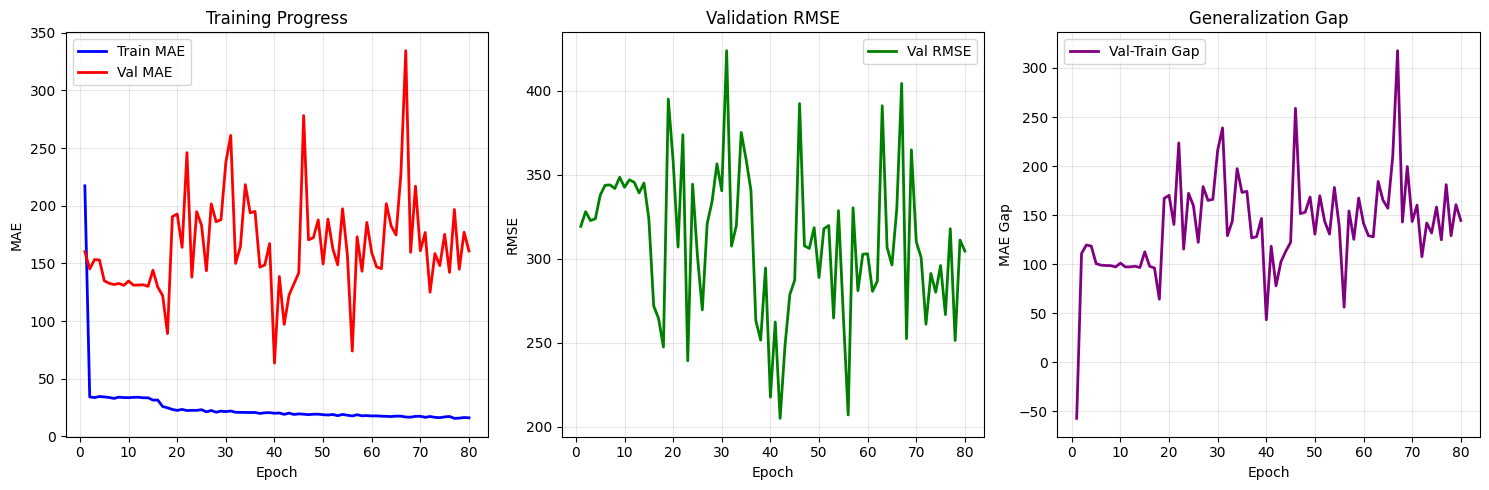

📈 Training Statistics:
   Final Train MAE: 16.158
   Final Val MAE: 160.804
   Final Val RMSE: 304.445
   Best Val MAE: 63.530
   Total Epochs: 80


In [13]:
# Plot training curves
if len(training_history['epoch']) > 0:
    plt.figure(figsize=(15, 5))

    # Training and validation MAE
    plt.subplot(1, 3, 1)
    plt.plot(training_history['epoch'], training_history['train_mae'], 'b-', label='Train MAE', linewidth=2)
    plt.plot(training_history['epoch'], training_history['val_mae'], 'r-', label='Val MAE', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Validation RMSE
    plt.subplot(1, 3, 2)
    plt.plot(training_history['epoch'], training_history['val_rmse'], 'g-', label='Val RMSE', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Learning curve analysis
    plt.subplot(1, 3, 3)
    train_mae = np.array(training_history['train_mae'])
    val_mae = np.array(training_history['val_mae'])
    gap = val_mae - train_mae
    plt.plot(training_history['epoch'], gap, 'purple', label='Val-Train Gap', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('MAE Gap')
    plt.title('Generalization Gap')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final statistics
    print("📈 Training Statistics:")
    print(f"   Final Train MAE: {training_history['train_mae'][-1]:.3f}")
    print(f"   Final Val MAE: {training_history['val_mae'][-1]:.3f}")
    print(f"   Final Val RMSE: {training_history['val_rmse'][-1]:.3f}")
    print(f"   Best Val MAE: {min(training_history['val_mae']):.3f}")
    print(f"   Total Epochs: {len(training_history['epoch'])}")
else:
    print("⚠️  No training history available. Please run the training loop first.")

📁 Loading best model checkpoint...
✅ Loaded model from epoch 40 with MAE 63.530

🎯 Final Evaluation - Ground Truth vs Predictions:
1722.jpg            : GT   10.0, Pred   16.1, Error   6.1
915.jpg             : GT  175.0, Pred  106.0, Error  69.0
6.jpg               : GT   10.0, Pred   55.3, Error  45.3
1406.jpg            : GT  658.0, Pred  931.3, Error 273.3
1293.jpg            : GT   29.0, Pred   43.4, Error  14.4
1464.jpg            : GT   53.0, Pred   70.3, Error  17.3
307.jpg             : GT   17.0, Pred   31.7, Error  14.7
1790.jpg            : GT   96.0, Pred   84.3, Error  11.7
418.jpg             : GT  351.0, Pred  459.8, Error 108.8
1720.jpg            : GT  196.0, Pred  206.5, Error  10.5
1891.jpg            : GT    3.0, Pred   17.4, Error  14.4
1249.jpg            : GT   24.0, Pred   16.7, Error   7.3
868.jpg             : GT   20.0, Pred   29.8, Error   9.8
903.jpg             : GT   13.0, Pred   21.2, Error   8.2
610.jpg             : GT    3.0, Pred   19.7, Error  16.7

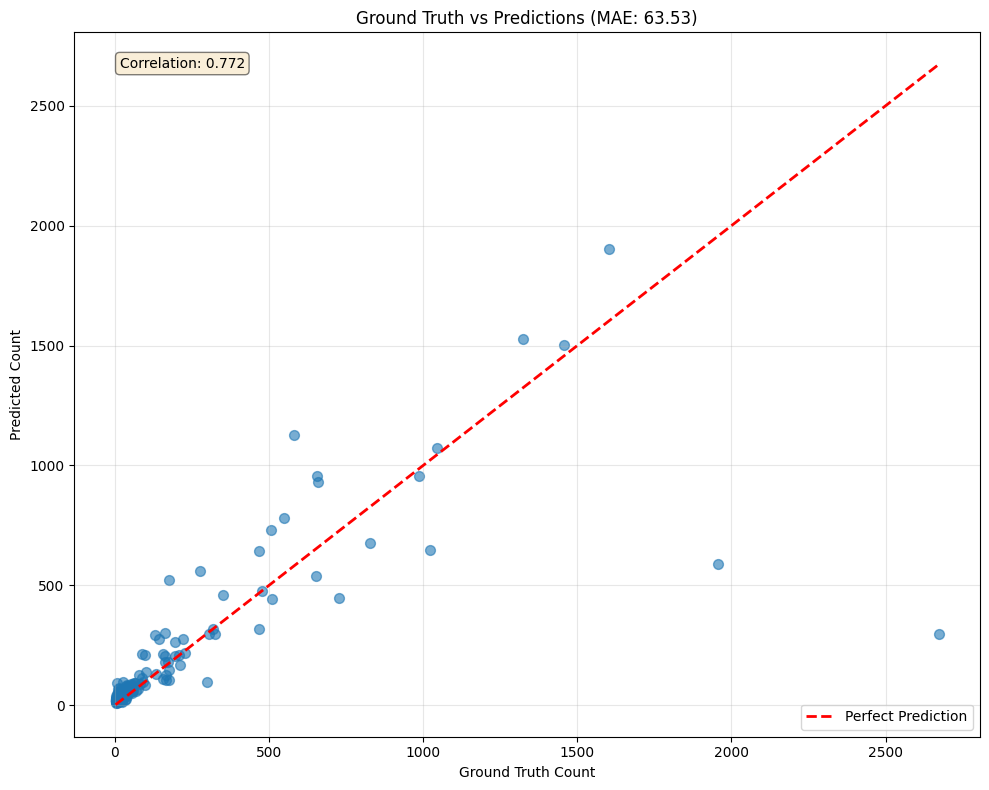


🔗 Correlation coefficient: 0.772


In [14]:
# Load best model for final evaluation
if os.path.exists(config['save_path']):
    print("📁 Loading best model checkpoint...")
    checkpoint = torch.load(config['save_path'], map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model"])
    print(f"✅ Loaded model from epoch {checkpoint['epoch']} with MAE {checkpoint['val_mae']:.3f}")

# Final evaluation with detailed predictions
print("\n🎯 Final Evaluation - Ground Truth vs Predictions:")
print("="*60)

model.eval()
predictions = []
ground_truths = []
image_names = []

with torch.no_grad():
    for batch_idx, (imgs, dens, _, occ) in enumerate(val_loader):
        imgs = imgs.to(device)
        dens = dens.to(device)
        pred_den, pred_det = model(imgs)

        # Use hybrid gating if enabled
        if config['hybrid_eval']:
            prob = torch.sigmoid(pred_det)
            w = (pred_den < config['dens_thresh']).float() * prob
            comb = (1.0 - w) * pred_den + w * prob
            pred_cnt_batch = comb.sum((1, 2, 3))
        else:
            pred_cnt_batch = pred_den.sum((1, 2, 3))

        gt_cnt_batch = dens.sum((1, 2, 3))

        # Store results
        for j in range(pred_cnt_batch.size(0)):
            idx = batch_idx * config['batch_size'] + j
            if idx < len(val_ds.img_paths):
                image_name = os.path.basename(val_ds.img_paths[idx])
                image_names.append(image_name)
                predictions.append(pred_cnt_batch[j].item())
                ground_truths.append(gt_cnt_batch[j].item())

                print(f"{image_name:20s}: GT {gt_cnt_batch[j].item():6.1f}, Pred {pred_cnt_batch[j].item():6.1f}, "
                      f"Error {abs(gt_cnt_batch[j].item() - pred_cnt_batch[j].item()):5.1f}")

# Calculate final metrics
if len(predictions) > 0:
    predictions = np.array(predictions)
    ground_truths = np.array(ground_truths)

    mae = np.mean(np.abs(predictions - ground_truths))
    mse = np.mean((predictions - ground_truths)**2)
    rmse = np.sqrt(mse)

    print("\n📊 Final Metrics:")
    print(f"   MAE:  {mae:.3f}")
    print(f"   MSE:  {mse:.3f}")
    print(f"   RMSE: {rmse:.3f}")

    # Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(ground_truths, predictions, alpha=0.6, s=50)

    # Perfect prediction line
    max_val = max(np.max(ground_truths), np.max(predictions))
    min_val = min(np.min(ground_truths), np.min(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    plt.xlabel('Ground Truth Count')
    plt.ylabel('Predicted Count')
    plt.title(f'Ground Truth vs Predictions (MAE: {mae:.2f})')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add correlation coefficient
    correlation = np.corrcoef(ground_truths, predictions)[0, 1]
    plt.text(
        0.05,
        0.95,
        f'Correlation: {correlation:.3f}',
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5)\
    )

    plt.tight_layout()
    plt.show()

    print(f"\n🔗 Correlation coefficient: {correlation:.3f}")
else:
    print("⚠️  No validation data processed.")

🎨 Visualizing sample predictions...


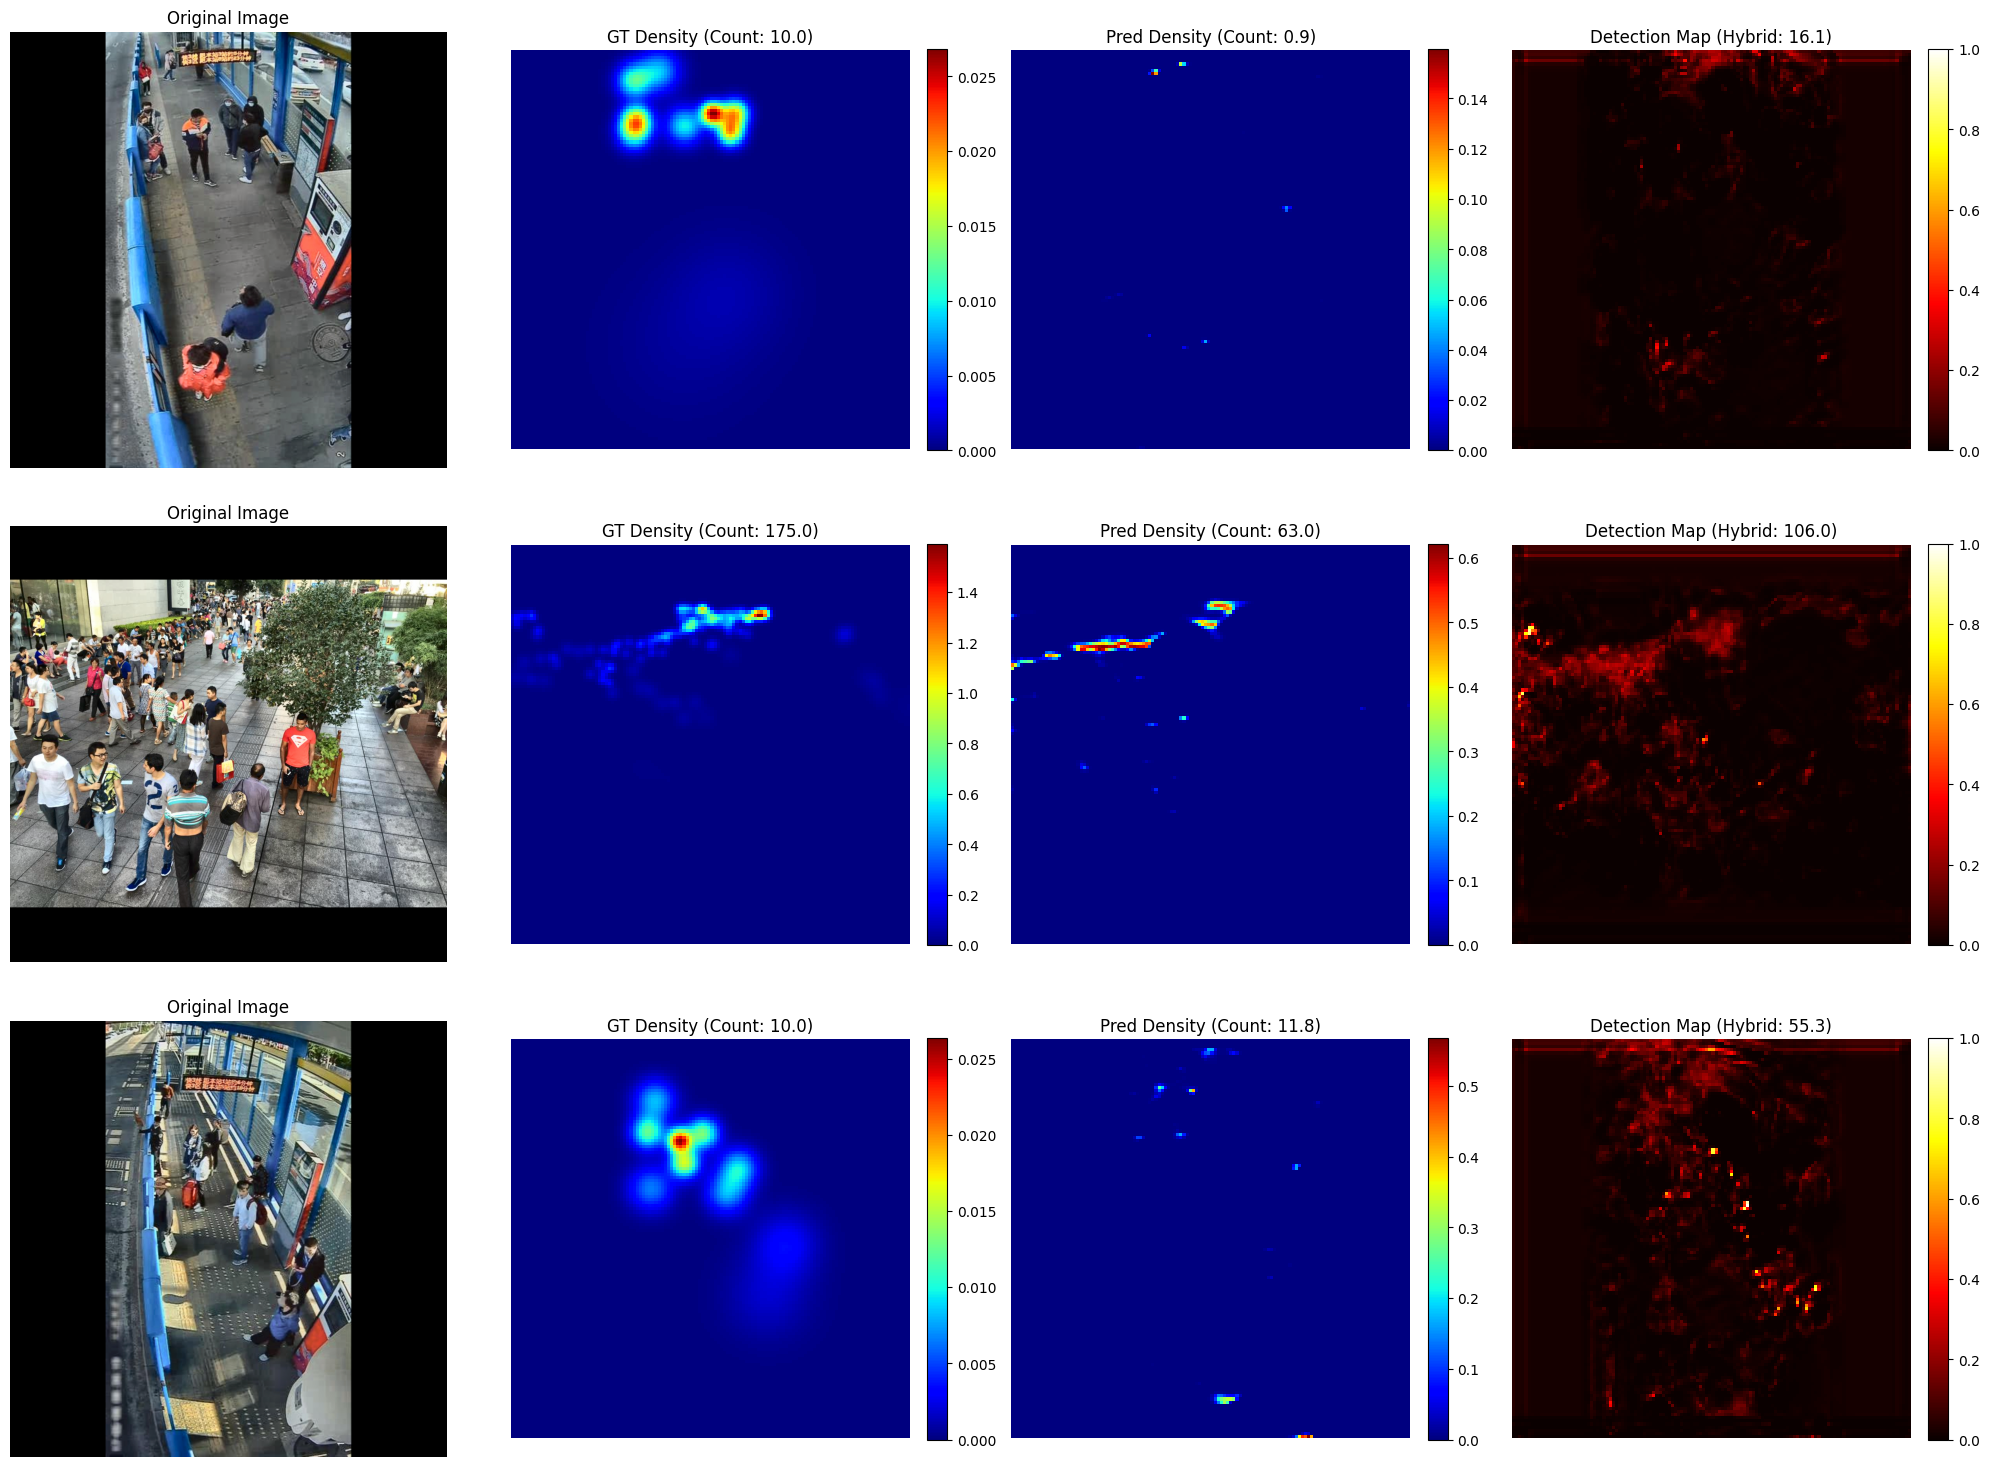


✅ Training and evaluation complete!
🎯 Final model saved at: sfcn_fpn_hybrid_896p384_b4_e300.pth
📊 Training history and visualizations have been generated above.


In [15]:
# Visualize sample predictions with density maps
def visualize_predictions(
    model,
    dataset,
    device,
    num_samples=4
):
    """Visualize model predictions with density maps."""
    model.eval()

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i in range(num_samples):
            if i >= len(dataset):
                break

            # Get sample
            img_tensor, gt_density, gt_count, gt_occ = dataset[i]
            img_tensor = img_tensor.unsqueeze(0).to(device)

            # Model prediction
            pred_density, pred_det = model(img_tensor)

            # Convert to numpy
            img_np = img_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
            img_np = img_np * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)  # Denormalize
            img_np = np.clip(img_np, 0, 1)

            gt_density_np = gt_density.squeeze().numpy()
            pred_density_np = pred_density.squeeze().cpu().numpy()
            pred_det_np = torch.sigmoid(pred_det).squeeze().cpu().numpy()

            # Calculate counts
            gt_count_val = gt_density_np.sum()
            pred_count_val = pred_density_np.sum()

            # Hybrid count if enabled
            if config['hybrid_eval']:
                prob = pred_det_np
                w = (pred_density_np < config['dens_thresh']).astype(float) * prob
                comb = (1.0 - w) * pred_density_np + w * prob
                hybrid_count = comb.sum()
            else:
                hybrid_count = pred_count_val

            # Plot original image
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title(f'Original Image')
            axes[i, 0].axis('off')

            # Plot ground truth density
            im1 = axes[i, 1].imshow(gt_density_np, cmap='jet')
            axes[i, 1].set_title(f'GT Density (Count: {gt_count_val:.1f})')
            axes[i, 1].axis('off')
            plt.colorbar(im1, ax=axes[i, 1], fraction=0.046, pad=0.04)

            # Plot predicted density
            im2 = axes[i, 2].imshow(pred_density_np, cmap='jet')
            axes[i, 2].set_title(f'Pred Density (Count: {pred_count_val:.1f})')
            axes[i, 2].axis('off')
            plt.colorbar(im2, ax=axes[i, 2], fraction=0.046, pad=0.04)

            # Plot detection map
            im3 = axes[i, 3].imshow(pred_det_np, cmap='hot', vmin=0, vmax=1)
            axes[i, 3].set_title(f'Detection Map (Hybrid: {hybrid_count:.1f})')
            axes[i, 3].axis('off')
            plt.colorbar(im3, ax=axes[i, 3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Visualize predictions if validation dataset exists
try:
    print("🎨 Visualizing sample predictions...")
    visualize_predictions(model, val_ds, device, num_samples=3)
except NameError:
    print("⚠️  Validation dataset not available. Please run the data preparation cells first.")

print("\n✅ Training and evaluation complete!")
print(f"🎯 Final model saved at: {config['save_path']}")
print("📊 Training history and visualizations have been generated above.")

## Test Prediction and Generate Submission

In [16]:
def generate_submission(model, test_loader, output_file="submission.csv"):
    model.eval()
    predictions, image_names = [], []

    with torch.no_grad():
        for images, names in test_loader:
            images = images.to(device)

            pred_den, pred_det = model(images)

            if config['hybrid_eval']:
                prob = torch.sigmoid(pred_det)
                w = (pred_den < config['dens_thresh']).float() * prob
                comb = (1.0 - w) * pred_den + w * prob
                batch_preds = comb.sum((1, 2, 3))
            else:
                batch_preds = pred_den.sum((1, 2, 3))

            # round the result so predicted_count will store as int
            predictions.extend(batch_preds.cpu().numpy().round().astype(int).tolist())

            image_names.extend(names)

    submission_df = pd.DataFrame({
        "image_id": image_names,
        "predicted_count": predictions
    })

    submission_df["sort_key"] = submission_df["image_id"].apply(lambda x: int(os.path.splitext(x)[0]))
    submission_df = submission_df.sort_values("sort_key").drop("sort_key", axis=1).reset_index(drop=True)

    submission_df.to_csv(output_file, index=False)
    print(f"✅ Submission saved to {output_file}")
    return submission_df

submission_df = generate_submission(
    model,
    test_loader,
)

submission_df.head(50)

✅ Submission saved to submission.csv


,image_id,predicted_count
0,1.jpg,25
1,2.jpg,57
2,3.jpg,216
3,4.jpg,1375
4,5.jpg,102
5,6.jpg,445
6,7.jpg,182
7,8.jpg,818
8,9.jpg,22
9,10.jpg,75
